In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('../data/forestfires.csv')
print("Первые 5 строк данных:")
display(df.head())

Первые 5 строк данных:


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


1. Предобработка данных

In [14]:
# Преобразование месяца в индикатор летнего сезона (июнь-сентябрь)
summer_months = ['jun', 'jul', 'aug', 'sep']
df['summer'] = df['month'].apply(lambda x: 1 if x in summer_months else 0)

# Удаление ненужных столбцов
df = df.drop(['month', 'day'], axis=1)

# Добавление константного признака
df['const'] = 1

# Логарифмирование целевой переменной (area) с добавлением константы c
def transform_area(x, c=1):
    return np.log(x + c)

# Разделение на признаки и целевую переменную
X = df.drop('area', axis=1)
y = df['area']

# Разделение данных на обучающую и тестовую выборки (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

2. Построение базовой модели

In [15]:
# Модель для исходных данных
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание и оценка качества
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Базовая модель MSE: {mse:.4f}")

Базовая модель MSE: 7925.7311


3. Модель с преобразованием целевой переменной

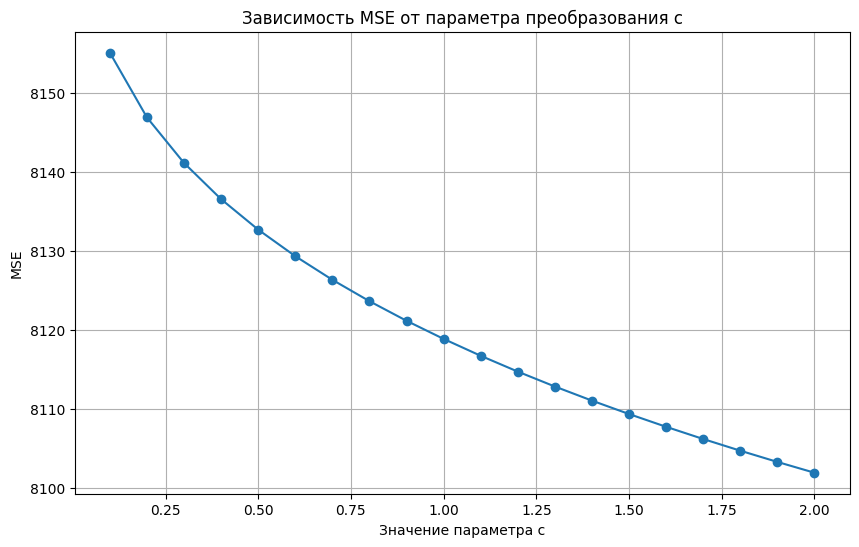

Оптимальное значение c: 2.00


In [16]:
# Подбор оптимального параметра c для преобразования
c_values = np.linspace(0.1, 2, 20)
mse_values = []

for c in c_values:
    # Преобразование целевой переменной
    y_train_transformed = transform_area(y_train, c)
    
    # Обучение модели
    model_transformed = LinearRegression()
    model_transformed.fit(X_train, y_train_transformed)
    
    # Предсказание и обратное преобразование
    y_pred_transformed = model_transformed.predict(X_test)
    y_pred_original = np.exp(y_pred_transformed) - c
    
    # Оценка качества
    mse_values.append(mean_squared_error(y_test, y_pred_original))

# Визуализация зависимости MSE от c
plt.figure(figsize=(10, 6))
plt.plot(c_values, mse_values, 'o-')
plt.xlabel('Значение параметра c')
plt.ylabel('MSE')
plt.title('Зависимость MSE от параметра преобразования c')
plt.grid(True)
plt.show()

# Оптимальное значение c
optimal_c = c_values[np.argmin(mse_values)]
print(f"Оптимальное значение c: {optimal_c:.2f}")

4. Проверка устойчивости модели

In [17]:
# Многократное разбиение данных с оптимальным c
mse_results = []

for i in range(10):
    # Новое разбиение
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
    # Преобразование с оптимальным c
    y_train_transformed = transform_area(y_train, optimal_c)
    
    # Обучение и предсказание
    model = LinearRegression()
    model.fit(X_train, y_train_transformed)
    y_pred_transformed = model.predict(X_test)
    y_pred_original = np.exp(y_pred_transformed) - optimal_c
    
    mse_results.append(mean_squared_error(y_test, y_pred_original))

# Результаты
print("Результаты при разных разбиениях:")
print(f"Среднее MSE: {np.mean(mse_results):.4f}")
print(f"Стандартное отклонение MSE: {np.std(mse_results):.4f}")

Результаты при разных разбиениях:
Среднее MSE: 3807.0089
Стандартное отклонение MSE: 2542.1107


5. Анализ важности признаков

In [18]:
# Обучение финальной модели на всех данных
y_transformed = transform_area(y, optimal_c)
final_model = LinearRegression()
final_model.fit(X, y_transformed)

# Коэффициенты модели
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': final_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("\nВажность признаков:")
display(coef_df)


Важность признаков:


,feature,coefficient
10,summer,-0.111695
8,wind,0.060422
9,rain,0.044026
0,X,0.034406
5,ISI,-0.019174
1,Y,0.006558
2,FFMC,0.005244
6,temp,0.005218
7,RH,-0.004348
3,DMC,0.001206


сохранение результатов

In [19]:
# Сохранение результатов
results = {
    'optimal_c': float(optimal_c),
    'base_mse': float(mse),
    'transformed_mse': float(np.min(mse_values)),
    'mse_std': float(np.std(mse_results)),
    'important_features': coef_df.head(3).to_dict()
}

import json
with open('../results/task3_results.json', 'w') as f:
    json.dump(results, f, indent=2)